In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import time
from scipy.stats import randint as sp_randint
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib
from operator import itemgetter

import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from tabulate import tabulate
from datetime import datetime

In [20]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [8]:
data = pd.read_csv('diabetes.csv')
n_features = len(data.columns)
target = data['Outcome']
data.drop(columns = 'Outcome', inplace = True)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12)

In [9]:
def classification_model(model, x_train, x_test, y_train, y_test):
    model_ = model
    model_.fit(x_train, y_train)
    y_hat_test = model_.predict(x_test)
    model_y_score = model_.decision_function(x_test)
#     model_y_score = model_.predict_proba(x_test)[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_y_score)
    return model_, fpr, tpr, thresholds, y_hat_test

In [10]:
def Print_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    true_negative  = cm[0,0]
    true_positive  = cm[1,1]
    false_negative = cm[1,0]
    false_positive = cm[0,1]
#     tpr = true_positive/(true_positive + false_negative)
#     fpr = false_positive/(false_positive + true_negative)
    total = true_negative + true_positive + false_negative + false_positive
    accuracy = (true_positive + true_negative)/total
    precision = (true_positive)/(true_positive + false_positive)
    recall = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1 = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('F1.......................%7.4f' % F1)
    print('auc......................%7.4f' % auc(fpr, tpr))

In [29]:
def plot_roc_curve(fpr, tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

In [12]:
# Model Parameter Grids Ranges

#Logistic Regression
param_grid1 = {'C': [0.001, 0.01, 0.1, 1, 10] }

#Random Forest
param_grid2 = {"n_estimators": range(20, 100, 2),
                  "max_depth": range(4, 40, 2),
                  "min_samples_leaf": range(2, 100, 2),
                  "max_features": range(1, n_features+1),
                  "min_samples_split": range(2, 10),
                  "bootstrap": [True],
                  "criterion": ["gini", "entropy"]}

#Gradient Boost
param_grid3 = {'n_estimators': [500],
                  'learning_rate':[0.001, 0.01,0.1],
                  'max_depth': [4,40,2],
                  'min_samples_leaf': range(2, 100, 2),
                  'min_samples_split': range(2, 10),
                  'max_features': range(1, n_features+1)}

#XGBoost
param_grid4 = {'min_child_weight': [1, 5, 10],
                   'learning_rate':[0.001, 0.01,0.1],
                   'gamma': [0.5, 1, 1.5, 2, 5],
                   'subsample': [0.6, 0.8, 1.0],
                   'colsample_bytree': [0.6, 0.8, 1.0],
                   'max_depth': [3, 4, 5]}

#AdaBoost
param_grid5 = {"base_estimator__criterion" : ["gini", "entropy"],
                   'learning_rate':[0.001, 0.01,0.1],
                   "base_estimator__splitter" :   ["best", "random"],
                   "n_estimators": [1, 2]}

In [36]:
def grid_search(clf, param_grid):
    global best_model, saved_model
    cv = ShuffleSplit(n_splits = 15, test_size = 0.20, random_state = 2)
    n_iter_search = 500
    estimator = GridSearchCV(clf,
                                   param_grid = param_grid,
                                   scoring = 'roc_auc',
                                   verbose = 0,
                                   cv = cv,
                                   n_jobs = 3)
        
    fit = estimator.fit(x_train, y_train)
    
    best_model = estimator.best_estimator_
    print('\nbest_model:\n', best_model)

#     print('\nFeature Importances:', best_model.feature_importances_)
    
    y_predicted = best_model.predict(x_train)
    probabilities = best_model.predict_proba(x_test)
    y_score = best_model.decision_function(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    
    plot_roc_curve(fpr, tpr)
    
    c_report = classification_report(y_train, y_predicted)
    print('\nClassification report:\n', c_report)
    return best_model, fit, probabilities, c_report, fpr, tpr, thresholds
    

## Random Forest Classifier

## Logistic Regression (has decision function)


best_model:
 LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.8337924701561065


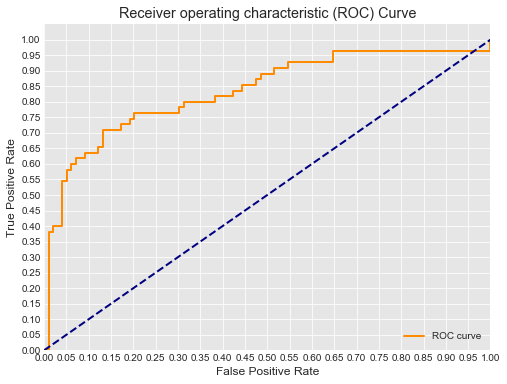


Classification report:
              precision    recall  f1-score   support

          0       0.85      0.77      0.81       401
          1       0.63      0.75      0.69       213

avg / total       0.78      0.76      0.77       614


 Time taken: 0 hours 0 minutes and 0.91 seconds.


In [39]:
start_time = timer(None)
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)
timer(start_time)

In [ ]:
data = pd.read_csv('diabetes.csv')

In [ ]:
n_features = len(data.columns)

In [ ]:
n_features

In [ ]:
target = data['Outcome']
data.drop(columns = 'Outcome', inplace = True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12)

In [ ]:
model_, fpr, tpr, thresholds, y_pred = classification_model(LogisticRegression(class_weight = 'balanced'), x_train, x_test, y_train, y_test)

In [ ]:
Print_confusion_matrix()
plot_roc_curve()

## AdaBoostClassifier (has decision function)

In [ ]:
model_, fpr, tpr, thresholds, y_pred = classification_model(AdaBoostClassifier(), x_train, x_test, y_train, y_test)

In [ ]:
Print_confusion_matrix()
plot_roc_curve()

## GradientBoostClassifier (has decision function)

In [ ]:
model_, fpr, tpr, thresholds, y_pred = classification_model(GradientBoostingClassifier(), x_train, x_test, y_train, y_test)

In [ ]:
Print_confusion_matrix()
plot_roc_curve()

## SVC (has decision function)

In [ ]:
model_, fpr, tpr, thresholds, y_pred = classification_model(SVC(), x_train, x_test, y_train, y_test)
Print_confusion_matrix()
plot_roc_curve()